# Credit Card Fraud Detection
### Based on the Kaggle [Fraud Detection Data](https://www.kaggle.com/code/zwhjorth/dnn-svm-and-dt-for-fraud-detection)

In [1]:
# Install all requirements needed to train this model and track it in MLFlow.
!pip install pip -qU
!pip install -r requirements.txt -q

In [2]:
# Import the dependencies we need to run the code.

import os
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns
import tf2onnx

import mlflow
from sklearn.linear_model import LogisticRegression

import keras
import tensorflow as tf

2025-08-06 00:28:04.309407: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754440084.333166    9672 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754440084.340467    9672 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-06 00:28:04.365476: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Get the external route for the MLFlow Server

In [3]:
# Get the environment variable for how to reach MLFlow.
# The general format is http://<route-to-mlflow>:<port> where you replace <route-to-mlflow> and <port> with specifics for where your MLFlow instance is set up and/or exposed.

MLFLOW_ROUTE = os.getenv("MLFLOW_ROUTE")

### Load the data into a pandas dataframe.

In [4]:
# Load the CSV data which we will use to train the model.
# It contains the following fields:
#   distancefromhome - The distance from home where the transaction happened.
#   distancefromlast_transaction - The distance from last transaction happened.
#   ratiotomedianpurchaseprice - Ratio of purchased price compared to median purchase price.
#   repeat_retailer - If it's from a retailer that already has been purchased from before.
#   used_chip - If the (credit card) chip was used.
#   usedpinnumber - If the PIN number was used.
#   online_order - If it was an online order.
#   fraud - If the transaction is fraudulent.

Data = pd.read_csv('../data/card_transdata.csv')
Data.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


### Split the data into training and test sets.

In [5]:
# Set the input (X) and output (Y) data. 
# The only output data we have is if it's fraudulent or not, and all other fields go as inputs to the model.

X = Data.drop(columns = ['fraud'])
y = Data['fraud']

# Split the data into training and testing sets so we have something to test the trained model with.

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, stratify = y)

X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size = 0.2, stratify = y_train)

# Scale the data to remove mean and have unit variance. This means that the data will be between -1 and 1, which makes it a lot easier for the model to learn than random potentially large values.
# It is important to only fit the scaler to the training data, otherwise you are leaking information about the global distribution of variables (which is influenced by the test set) into the training set.

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)

# Since the dataset is unbalanced (it has many more non-fraud transactions than fraudulent ones), we set a class weight to weight the few fraudulent transactions higher than the many non-fraud transactions.

class_weights = class_weight.compute_class_weight('balanced',classes = np.unique(y_train),y = y_train)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

### Build the DNN model

In [6]:
# Build the model, the model we build here is a simple fully connected deep neural network, containing 3 hidden layers and one output layer.

model = Sequential()
model.add(Dense(32, name='dense', activation = 'relu', input_dim = len(X.columns)))
model.add(Dropout(0.2))
model.add(Dense(32, name='dense_02'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(32, name='dense_03'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1, name='dense_04', activation = 'sigmoid'))
model.compile(optimizer='SGD',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

/opt/app-root/lib64/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-08-06 00:28:14.312637: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_02 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_03 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_04 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,657 (10.38 KB)

 Trainable params: 2,529 (9.88 KB)

 Non-trainable params: 128 (512.00 B)

### Configure MLFlow

In [7]:
# Set up tracking to MLFlow by using the route from earlier. We call the experiment and model DNN-credit-fraud.
# We also enable autologging for MLFlow so we don't have to manually log the model or any metrics besides custom ones.

mlflow.set_tracking_uri(MLFLOW_ROUTE)
mlflow.set_experiment("DNN-credit-card-fraud")
mlflow.tensorflow.autolog(registered_model_name="DNN-credit-card-fraud")

2025/08/06 00:28:15 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.


### Train the model, plot the confusion matrix and push the artifacts to MLFlow.

2025/08/06 00:28:15 WARNING mlflow.tensorflow: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


Epoch 1/2
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 51s 2ms/step - accuracy: 0.9167 - loss: 0.1902 - val_accuracy: 0.9645 - val_loss: 0.0875
Epoch 2/2
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - accuracy: 0.9656 - loss: 0.0821 - val_accuracy: 0.9592 - val_loss: 0.1134
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


2025/08/06 00:29:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=/tmp/tmprq_ix29_/model/data/model.


6250/6250 ━━━━━━━━━━━━━━━━━━━━ 5s 718us/step


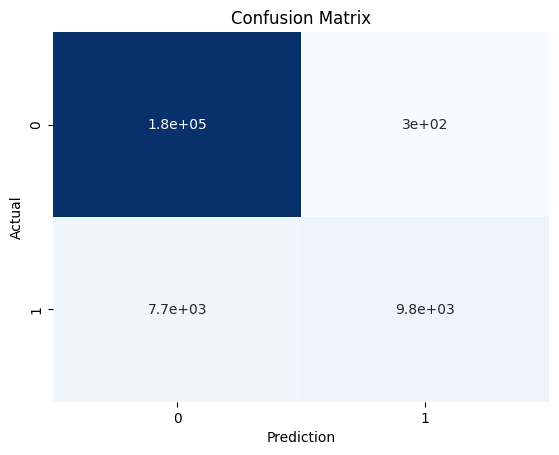

I0000 00:00:1754440197.124671    9672 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00:1754440197.124819    9672 single_machine.cc:361] Starting new session
I0000 00:00:1754440197.279313    9672 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00:1754440197.279458    9672 single_machine.cc:361] Starting new session
/opt/app-root/lib64/python3.11/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


In [8]:
# Train the model.
# We wrap the training with an mlflow wrapper to signify that this is an experiment run.
# We also define a few more metrics at the very bottom to track the confusion matrix in MLFlow.

with mlflow.start_run():
    epochs = 2
    history = model.fit(X_train, y_train, epochs=epochs, \
                        validation_data=(scaler.transform(X_val),y_val), \
                        verbose = True, class_weight = class_weights)

    y_pred_temp = model.predict(scaler.transform(X_test)) 

    threshold = 0.995

    y_pred = np.where(y_pred_temp > threshold, 1,0)
    c_matrix = confusion_matrix(y_test,y_pred)
    ax = sns.heatmap(c_matrix, annot=True, cbar=False, cmap='Blues')
    ax.set_xlabel("Prediction")
    ax.set_ylabel("Actual")
    ax.set_title('Confusion Matrix')
    plt.show()

    t_n, f_p, f_n, t_p = c_matrix.ravel()
    mlflow.log_metric("tn", t_n)
    mlflow.log_metric("fp", f_p)
    mlflow.log_metric("fn", f_n)
    mlflow.log_metric("tp", t_p)

    # Normally we use tf2.onnx.convert.from_keras.
    # workaround for tf2onnx bug https://github.com/onnx/tensorflow-onnx/issues/2348

    # Wrap the model in a `tf.function`
    @tf.function(input_signature=[tf.TensorSpec([None, X_train.shape[1]], tf.float32, name='dense_input')])
    def model_fn(x):
        return model(x)
    
    # Convert the Keras model to ONNX
    model_proto, _ = tf2onnx.convert.from_function(
        model_fn,
        input_signature=[tf.TensorSpec([None, X_train.shape[1]], tf.float32, name='dense_input')]
    )

    # model_proto,_ = tf2onnx.convert.from_keras(model)
    mlflow.onnx.log_model(model_proto, "models")    

### Save the model locally in ONNX format.

In [9]:
import onnx
onnx.save(model_proto, "fraud.onnx")